<h1>Telecom churn case study</h1>

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months

In [1]:
## import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)

In [2]:
# import model related libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [3]:
def check_columns_with_70percent_nulls(df):
    '''
    Function checks which columns have more than 70% missing values
    and returns dictionary with column names as keys and percentage of missing values as values
    
    Parameters:
        df(pandas.DataFrame): Dataframe
        
    Returns:
        dict_of_70(dict): resulting dictionary
    ----
    
    '''

    columns = list(df.columns)
    dict_of_70 = {
        column: df[column].isnull().sum()/len(df)*100 for column in columns if df[column].isnull().sum()/len(df)*100 >=70
    }
    
    return dict(sorted(dict_of_70.items(), key=lambda item: item[1], reverse=True))

In [4]:
def drop_given_columns(list_of_columns, df):
    '''
    Function drop given columns and returns resulting dataframe
    
    Parameters:
        list_of_columns(list): list of columns to drop
        df(pandas.DataFrame): Dataframe
        
    Returns:
        df(pandas.DataFrame): resulting Dataframe
    
    ----
    '''

    df = df.drop(columns=list_of_columns)
    
    return df

In [5]:
def display_columns_with_missing_values_and_its_percentage(df):
    '''
    Function returns dictionary with columns as keys that have missing values
    and their percentages of missing values as values
    
    Parameters:
        df(pandas.DataFrame): Dataframe
        
    Returns:
        dict_of_columns_to_impute(dict): resulting dictionary
    
    ----
    '''

    columns = list(df.columns)
    dict_of_columns_to_impute = {
        column: df[column].isnull().sum()/len(df)*100 for column in columns if df[column].isnull().sum()/len(df)*100 > 0
    }
    return dict(sorted(dict_of_columns_to_impute.items(), key=lambda item: item[1], reverse=True))

In [6]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [7]:
def distplot(var):
    sns.distplot(var)

In [8]:
def boxplot(var1, var2):
    sns.boxplot(var1, var2)

In [9]:
def sensitivity_and_specificity(confusionmatrix):
    TP = confusionmatrix[1,1]
    TN = confusionmatrix[0,0]
    FP = confusionmatrix[0,1]
    FN = confusionmatrix[1,0]
    #Sensitivity
    print("Sensitivity: ", TP/float(TP+FN))
    #Specificity
    print("Specificity: ", TN/float(TN+FP))  

<h1>1.Data Loading</h1>

In [10]:
# Load the data
telecom_df = pd.read_csv('telecom_churn_data.csv')

In [11]:
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [12]:
telecom_df.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

In [13]:
telecom_df.shape

(99999, 226)

In [14]:
telecom_df.describe

<bound method NDFrame.describe of        mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
0         7000842753        109             0.0             0.0   
1         7001865778        109             0.0             0.0   
2         7001625959        109             0.0             0.0   
3         7001204172        109             0.0             0.0   
4         7000142493        109             0.0             0.0   
...              ...        ...             ...             ...   
99994     7001548952        109             0.0             0.0   
99995     7000607688        109             0.0             0.0   
99996     7000087541        109             0.0             0.0   
99997     7000498689        109             0.0             0.0   
99998     7001905007        109             0.0             0.0   

       loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
0                 0.0            6/30/2014            7/31/2014   
1                 0.0      

<h1>2.Data Cleaning and Handling missing data</h1>

In [15]:
# Check for missing data
column_with_missing_values = display_columns_with_missing_values_and_its_percentage(telecom_df)
column_with_missing_values

{'date_of_last_rech_data_6': 74.84674846748467,
 'total_rech_data_6': 74.84674846748467,
 'max_rech_data_6': 74.84674846748467,
 'count_rech_2g_6': 74.84674846748467,
 'count_rech_3g_6': 74.84674846748467,
 'av_rech_amt_data_6': 74.84674846748467,
 'arpu_3g_6': 74.84674846748467,
 'arpu_2g_6': 74.84674846748467,
 'night_pck_user_6': 74.84674846748467,
 'fb_user_6': 74.84674846748467,
 'date_of_last_rech_data_7': 74.42874428744287,
 'total_rech_data_7': 74.42874428744287,
 'max_rech_data_7': 74.42874428744287,
 'count_rech_2g_7': 74.42874428744287,
 'count_rech_3g_7': 74.42874428744287,
 'av_rech_amt_data_7': 74.42874428744287,
 'arpu_3g_7': 74.42874428744287,
 'arpu_2g_7': 74.42874428744287,
 'night_pck_user_7': 74.42874428744287,
 'fb_user_7': 74.42874428744287,
 'date_of_last_rech_data_9': 74.07774077740777,
 'total_rech_data_9': 74.07774077740777,
 'max_rech_data_9': 74.07774077740777,
 'count_rech_2g_9': 74.07774077740777,
 'count_rech_3g_9': 74.07774077740777,
 'av_rech_amt_data_9

In [16]:
## Identifying the categorical columns based on the data dictionary

categorical_columns =  ['fb_user_6',
             'fb_user_7',
             'fb_user_8',
             'fb_user_9',
             'night_pck_user_6',
             'night_pck_user_7',
             'night_pck_user_8',
             'night_pck_user_9'
            ]

In [17]:
## Identifying the date columns based on the data dictionary

date_cols = ['last_date_of_month_6',
             'last_date_of_month_7',
             'last_date_of_month_8',
             'last_date_of_month_9',
             'date_of_last_rech_6',
             'date_of_last_rech_7',
             'date_of_last_rech_8',
             'date_of_last_rech_9',
             'date_of_last_rech_data_6',
             'date_of_last_rech_data_7',
             'date_of_last_rech_data_8',
             'date_of_last_rech_data_9'
            ]

###### The above listed date columns  do not contribute much to the prediction.Also the columns 'mobile_number', 'circle_id' do not offer much patterns for forming our predictive model.Hence we can drop alll the date and id columns

In [18]:
## Removing the date columns which are not required for the analysis

telecom_df = drop_given_columns(date_cols , df = telecom_df)

In [19]:
## Removing the id columns which are not required for the analysis, 
## since mobile number is unique for each row and circle_id is same for all , we cannot establish any patterns out of it

id_cols = ['mobile_number', 'circle_id']
telecom_df = drop_given_columns(id_cols , df = telecom_df)


In [20]:
#Checking the shape after deleting date and id columns
telecom_df.shape

(99999, 212)

In [21]:
#Inspecting again for missing values
column_with_missing_values = display_columns_with_missing_values_and_its_percentage(telecom_df)
column_with_missing_values

{'total_rech_data_6': 74.84674846748467,
 'max_rech_data_6': 74.84674846748467,
 'count_rech_2g_6': 74.84674846748467,
 'count_rech_3g_6': 74.84674846748467,
 'av_rech_amt_data_6': 74.84674846748467,
 'arpu_3g_6': 74.84674846748467,
 'arpu_2g_6': 74.84674846748467,
 'night_pck_user_6': 74.84674846748467,
 'fb_user_6': 74.84674846748467,
 'total_rech_data_7': 74.42874428744287,
 'max_rech_data_7': 74.42874428744287,
 'count_rech_2g_7': 74.42874428744287,
 'count_rech_3g_7': 74.42874428744287,
 'av_rech_amt_data_7': 74.42874428744287,
 'arpu_3g_7': 74.42874428744287,
 'arpu_2g_7': 74.42874428744287,
 'night_pck_user_7': 74.42874428744287,
 'fb_user_7': 74.42874428744287,
 'total_rech_data_9': 74.07774077740777,
 'max_rech_data_9': 74.07774077740777,
 'count_rech_2g_9': 74.07774077740777,
 'count_rech_3g_9': 74.07774077740777,
 'av_rech_amt_data_9': 74.07774077740777,
 'arpu_3g_9': 74.07774077740777,
 'arpu_2g_9': 74.07774077740777,
 'night_pck_user_9': 74.07774077740777,
 'fb_user_9': 74

In [22]:
# create a list of recharge columns 
recharge_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
        'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
        'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9'
       ]

In [23]:
# the missing values in recharge column indicate there has been no recharge done for those period.hence we can impute such NaN with 0
# impute missing values with zero values
telecom_df[recharge_cols] = telecom_df[recharge_cols].apply(lambda x: x.fillna(0))

In [24]:
print(telecom_df['night_pck_user_6'].unique())
print(telecom_df['night_pck_user_7'].unique())
print(telecom_df['night_pck_user_8'].unique())
print(telecom_df['night_pck_user_9'].unique())
print(telecom_df['fb_user_6'].unique())
print(telecom_df['fb_user_7'].unique())
print(telecom_df['fb_user_8'].unique())
print(telecom_df['fb_user_9'].unique())

[ 0. nan  1.]
[ 0. nan  1.]
[ 0. nan  1.]
[nan  0.  1.]
[ 1. nan  0.]
[ 1. nan  0.]
[ 1. nan  0.]
[nan  1.  0.]


In [25]:
# replace missing values with 'mode' in categorical columns
telecom_df[categorical_columns]=telecom_df[categorical_columns].fillna(telecom_df.mode().iloc[0])

In [26]:
# Check for columns with more than 70 percent missing values

dict_of_70percent_and_more_nulls = check_columns_with_70percent_nulls(telecom_df)
print(dict_of_70percent_and_more_nulls)

{'count_rech_2g_6': 74.84674846748467, 'count_rech_3g_6': 74.84674846748467, 'arpu_3g_6': 74.84674846748467, 'arpu_2g_6': 74.84674846748467, 'count_rech_2g_7': 74.42874428744287, 'count_rech_3g_7': 74.42874428744287, 'arpu_3g_7': 74.42874428744287, 'arpu_2g_7': 74.42874428744287, 'count_rech_2g_9': 74.07774077740777, 'count_rech_3g_9': 74.07774077740777, 'arpu_3g_9': 74.07774077740777, 'arpu_2g_9': 74.07774077740777, 'count_rech_2g_8': 73.66073660736608, 'count_rech_3g_8': 73.66073660736608, 'arpu_3g_8': 73.66073660736608, 'arpu_2g_8': 73.66073660736608}


In [27]:
telecom_df.shape

(99999, 212)

In [28]:
## Removing the columns which are having missing percentage as greater than 70 percent

telecom_df = drop_given_columns(dict_of_70percent_and_more_nulls , df = telecom_df)

In [29]:
telecom_df.shape

(99999, 196)

In [30]:
column_with_missing_values = display_columns_with_missing_values_and_its_percentage(telecom_df)
column_with_missing_values

{'onnet_mou_9': 7.745077450774509,
 'offnet_mou_9': 7.745077450774509,
 'roam_ic_mou_9': 7.745077450774509,
 'roam_og_mou_9': 7.745077450774509,
 'loc_og_t2t_mou_9': 7.745077450774509,
 'loc_og_t2m_mou_9': 7.745077450774509,
 'loc_og_t2f_mou_9': 7.745077450774509,
 'loc_og_t2c_mou_9': 7.745077450774509,
 'loc_og_mou_9': 7.745077450774509,
 'std_og_t2t_mou_9': 7.745077450774509,
 'std_og_t2m_mou_9': 7.745077450774509,
 'std_og_t2f_mou_9': 7.745077450774509,
 'std_og_t2c_mou_9': 7.745077450774509,
 'std_og_mou_9': 7.745077450774509,
 'isd_og_mou_9': 7.745077450774509,
 'spl_og_mou_9': 7.745077450774509,
 'og_others_9': 7.745077450774509,
 'loc_ic_t2t_mou_9': 7.745077450774509,
 'loc_ic_t2m_mou_9': 7.745077450774509,
 'loc_ic_t2f_mou_9': 7.745077450774509,
 'loc_ic_mou_9': 7.745077450774509,
 'std_ic_t2t_mou_9': 7.745077450774509,
 'std_ic_t2m_mou_9': 7.745077450774509,
 'std_ic_t2f_mou_9': 7.745077450774509,
 'std_ic_t2o_mou_9': 7.745077450774509,
 'std_ic_mou_9': 7.745077450774509,
 'sp

In [31]:
# replace the missing values with the median for that respective column
missing_cols = telecom_df.columns[telecom_df.isnull().sum()>0]
for col in missing_cols:
    telecom_df[col].fillna((telecom_df[col].median()), inplace=True)

In [32]:
column_with_missing_values = display_columns_with_missing_values_and_its_percentage(telecom_df)
column_with_missing_values

{}

##### This shows that the dataset has no missing values

<h1>3.Filter High Value Customers<h2>

##### Since 6th and 7th months have been marked as 'Good' phase we need to first find the Total Recharge Amount in each of these months for the customers.
##### The Total Recharge Amount  is essentially the sum of Total Calling Recharge Amount and Total Data Recharge Amount.
##### The total Data Recharge Amount can be derived as a product of  average recharge amount data and count of total data recharges
##### So here we need to make derived columns to find the Total Recharge amount

In [33]:
# step - 1 - Calculate Data Recharge amount for June and July month each

telecom_df['total_data_rech_6'] = telecom_df.total_rech_data_6 * telecom_df.av_rech_amt_data_6
telecom_df['total_data_rech_7'] = telecom_df.total_rech_data_7 * telecom_df.av_rech_amt_data_7

In [34]:
# step - 2 - Calculate Total Recharge amount for June and July month each

telecom_df['total_rech_amt_data_6'] = telecom_df.total_data_rech_6 + telecom_df.total_rech_amt_6
telecom_df['total_rech_amt_data_7'] = telecom_df.total_data_rech_7 + telecom_df.total_rech_amt_7

In [35]:
# step - 3 Calculate average recharge amount for months June and July

telecom_df['total_rech_amt_data_avg'] = (telecom_df.total_rech_amt_data_6 + telecom_df.total_rech_amt_data_7) / 2

In [36]:
# step - 4 - Look for 70th percentile data in order to filter the high value customers

telecom_df['total_rech_amt_data_avg'].quantile(0.7)

478.0

In [37]:
telecom_df['total_rech_amt_data_avg'].head()

0    559.0
1    306.0
2    241.5
3    270.0
4    301.0
Name: total_rech_amt_data_avg, dtype: float64

In [38]:
telecom_df.shape

(99999, 201)

In [39]:
# step - 4 - Retain only high value customers with more than or equal to 70th percentile amount

telecom_df = telecom_df.loc[(telecom_df['total_rech_amt_data_avg'] >= telecom_df['total_rech_amt_data_avg'].quantile(0.7))]

In [40]:
telecom_df.shape

(30001, 201)

# 4.Derive Churn

In [41]:
# calculate total incoming and outgoing minutes of usage
telecom_df['total_calls_mou_9'] = telecom_df.total_ic_mou_9 + telecom_df.total_og_mou_9
#telecom_df['total_calls_mou_9']

# calculate 2g and 3g data consumption
telecom_df['total_internet_mb_9'] =  telecom_df.vol_2g_mb_9 + telecom_df.vol_3g_mb_9

# create churn variable: those who have not used either calls or internet in the month of September are customers who have churned
# 0 - not churn, 1 - churn
telecom_df['churn'] = telecom_df.apply(lambda row: 1 if (row.total_calls_mou_9 == 0 and row.total_internet_mb_9 == 0) else 0, axis=1)

In [42]:
# change data type to category
telecom_df.churn = telecom_df.churn.astype("category")

# churn percentage
print("Churn Percentage - ")
print(telecom_df.churn.value_counts()*100/telecom_df.shape[0])

Churn Percentage - 
0    91.863605
1     8.136395
Name: churn, dtype: float64


##### So here we see that 92% customers have not churned whereas only 8% have churned.
##### This indicates class imbalance which needs to be dealt with later on

In [43]:
categorical_columns.append('churn')

##### All the columns that are KPI indicators of 9th month do not help us in prediction .hence we shall drop them

In [44]:
# delete all variables relating to 9th month
telecom_df = telecom_df.filter(regex='[^9]$', axis=1)
telecom_df.shape

(30001, 155)

<h1>5.Data Understanding and Data Preparation</h1>

## 5.1 Derive difference columns

##### The  difference between the 8th month KPI s and the average of 6 and 7 month's KPI should be indicative of the consumer behaviour and their tendencies to churn
##### The few important KPIs to consider are arpu,local_og_mou,local_ic_mou,isd_ic_mou,isd_og_mou,roam_ic_mou,roam_og_mou

In [45]:
telecom_df['arpu_diff'] = telecom_df.arpu_8 - ((telecom_df.arpu_6 + telecom_df.arpu_7)/2)

telecom_df['onnet_mou_diff'] = telecom_df.onnet_mou_8 - ((telecom_df.onnet_mou_6 + telecom_df.onnet_mou_7)/2)

telecom_df['offnet_mou_diff'] = telecom_df.offnet_mou_8 - ((telecom_df.offnet_mou_6 + telecom_df.offnet_mou_7)/2)

telecom_df['roam_ic_mou_diff'] = telecom_df.roam_ic_mou_8 - ((telecom_df.roam_ic_mou_6 + telecom_df.roam_ic_mou_7)/2)

telecom_df['roam_og_mou_diff'] = telecom_df.roam_og_mou_8 - ((telecom_df.roam_og_mou_6 + telecom_df.roam_og_mou_7)/2)

telecom_df['loc_og_mou_diff'] = telecom_df.loc_og_mou_8 - ((telecom_df.loc_og_mou_6 + telecom_df.loc_og_mou_7)/2)

telecom_df['std_og_mou_diff'] = telecom_df.std_og_mou_8 - ((telecom_df.std_og_mou_6 + telecom_df.std_og_mou_7)/2)

telecom_df['isd_og_mou_diff'] = telecom_df.isd_og_mou_8 - ((telecom_df.isd_og_mou_6 + telecom_df.isd_og_mou_7)/2)

telecom_df['spl_og_mou_diff'] = telecom_df.spl_og_mou_8 - ((telecom_df.spl_og_mou_6 + telecom_df.spl_og_mou_7)/2)

telecom_df['total_og_mou_diff'] = telecom_df.total_og_mou_8 - ((telecom_df.total_og_mou_6 + telecom_df.total_og_mou_7)/2)

telecom_df['loc_ic_mou_diff'] = telecom_df.loc_ic_mou_8 - ((telecom_df.loc_ic_mou_6 + telecom_df.loc_ic_mou_7)/2)

telecom_df['std_ic_mou_diff'] = telecom_df.std_ic_mou_8 - ((telecom_df.std_ic_mou_6 + telecom_df.std_ic_mou_7)/2)

telecom_df['isd_ic_mou_diff'] = telecom_df.isd_ic_mou_8 - ((telecom_df.isd_ic_mou_6 + telecom_df.isd_ic_mou_7)/2)

telecom_df['spl_ic_mou_diff'] = telecom_df.spl_ic_mou_8 - ((telecom_df.spl_ic_mou_6 + telecom_df.spl_ic_mou_7)/2)

telecom_df['total_ic_mou_diff'] = telecom_df.total_ic_mou_8 - ((telecom_df.total_ic_mou_6 + telecom_df.total_ic_mou_7)/2)

telecom_df['total_rech_num_diff'] = telecom_df.total_rech_num_8 - ((telecom_df.total_rech_num_6 + telecom_df.total_rech_num_7)/2)

telecom_df['total_rech_amt_diff'] = telecom_df.total_rech_amt_8 - ((telecom_df.total_rech_amt_6 + telecom_df.total_rech_amt_7)/2)

telecom_df['max_rech_amt_diff'] = telecom_df.max_rech_amt_8 - ((telecom_df.max_rech_amt_6 + telecom_df.max_rech_amt_7)/2)

telecom_df['total_rech_data_diff'] = telecom_df.total_rech_data_8 - ((telecom_df.total_rech_data_6 + telecom_df.total_rech_data_7)/2)

telecom_df['max_rech_data_diff'] = telecom_df.max_rech_data_8 - ((telecom_df.max_rech_data_6 + telecom_df.max_rech_data_7)/2)

telecom_df['av_rech_amt_data_diff'] = telecom_df.av_rech_amt_data_8 - ((telecom_df.av_rech_amt_data_6 + telecom_df.av_rech_amt_data_7)/2)

telecom_df['vol_2g_mb_diff'] = telecom_df.vol_2g_mb_8 - ((telecom_df.vol_2g_mb_6 + telecom_df.vol_2g_mb_7)/2)

telecom_df['vol_3g_mb_diff'] = telecom_df.vol_3g_mb_8 - ((telecom_df.vol_3g_mb_6 + telecom_df.vol_3g_mb_7)/2)

In [46]:
#create a list of numerical columns
num_cols = [column for column in telecom_df.columns if column not in categorical_columns]

In [47]:
# delete all variables relating to 9th month and remove churn from the categorical variable
categorical_columns.remove('fb_user_9')
categorical_columns.remove('night_pck_user_9')
categorical_columns.remove('churn')
categorical_columns

['fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8']

<h2>5.2 EDA</h2>

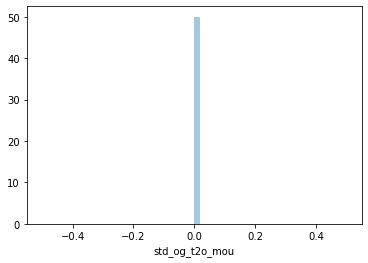

In [48]:
distplot(telecom_df.std_og_t2o_mou)

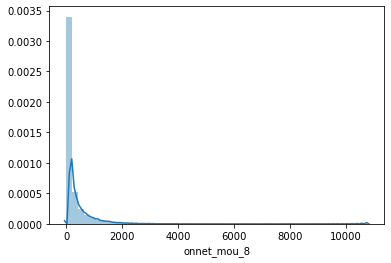

In [49]:
distplot(telecom_df.onnet_mou_8)

##### Insight: For the 8th(action) month the on network usage data is left skewed

#### aon vs churn

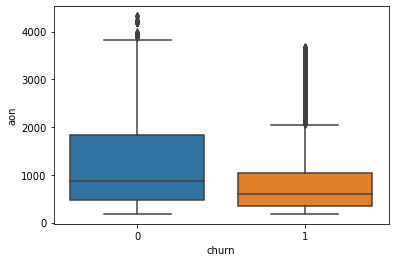

In [50]:
boxplot(telecom_df.churn, telecom_df.aon)

##### Insight: The churn is mostly for customers with lower values of aon.

#### arpu vs churn

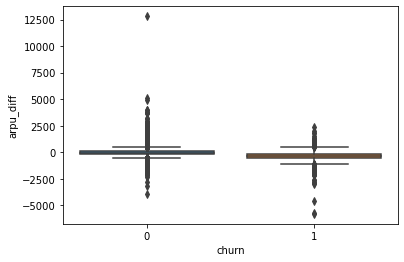

In [51]:
boxplot(telecom_df.churn, telecom_df.arpu_diff)

##### Insight: Churn is higher  for customers whose arpu in the 8th month has dropped significantly as compared to the 6th and 7th month taken together.

<h2>5.3 Removing Outliers</h2>

In [52]:
# outlier treatment using k-sigma method
telecom_df[num_cols] = telecom_df[num_cols].apply(cap_outliers, axis=0)

<h2>5.4 Creating Dummy Variables using One-hot Encoding</h2>

In [53]:
## converting categorical column to datatype category

telecom_df[categorical_columns]=telecom_df[categorical_columns].astype('category')
telecom_df[categorical_columns].dtypes

fb_user_6           category
fb_user_7           category
fb_user_8           category
night_pck_user_6    category
night_pck_user_7    category
night_pck_user_8    category
dtype: object

In [54]:
dummy1 = pd.get_dummies(telecom_df[categorical_columns],drop_first=True)
# Adding the results to the master dataframe
telecom_df = pd.concat([telecom_df, dummy1], axis=1)
#dropping the repeated variables
telecom_df=telecom_df.drop(categorical_columns,axis=1)
telecom_df.columns

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'offnet_mou_6',
       ...
       'max_rech_data_diff', 'av_rech_amt_data_diff', 'vol_2g_mb_diff',
       'vol_3g_mb_diff', 'fb_user_6_1.0', 'fb_user_7_1.0', 'fb_user_8_1.0',
       'night_pck_user_6_1.0', 'night_pck_user_7_1.0', 'night_pck_user_8_1.0'],
      dtype='object', length=178)

<h2>5.5 Train-test split</h2>

In [55]:
# change churn to numeric
telecom_df['churn'] = pd.to_numeric(telecom_df['churn'])

In [56]:
# divide data into train and test
X = telecom_df.drop("churn", axis = 1)
y = telecom_df.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state = 100, stratify = y)

In [57]:
# print shapes of train and test sets
X_train.shape

(21000, 177)

In [58]:
y_train.shape

(21000,)

In [59]:
X_test.shape

(9001, 177)

In [60]:
y_test.shape

(9001,)

<h1>6.Modelling</h1>

<h2> 6.1 PCA</h2>

In [61]:
# apply pca to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [62]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

In [63]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

# look at explainded variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0       10.56
1       19.23
2       25.02
3       29.92
4       34.38
5       37.98
6       40.68
7       43.17
8       45.47
9       47.59
10      49.56
11      51.33
12      53.09
13      54.76
14      56.39
15      57.89
16      59.32
17      60.65
18      61.96
19      63.26
20      64.50
21      65.68
22      66.81
23      67.89
24      68.95
25      69.96
26      70.91
27      71.84
28      72.72
29      73.59
30      74.45
31      75.27
32      76.07
33      76.86
34      77.63
35      78.39
36      79.10
37      79.80
38      80.47
39      81.13
40      81.76
41      82.37
42      82.96
43      83.51
44      84.04
45      84.56
46      85.06
47      85.54
48      86.01
49      86.47
50      86.93
51      87.37
52      87.79
53      88.18
54      88.57
55      88.95
56      89.31
57      89.67
58      90.00
59      90.32
60      90.64
61      90.95
62      91.25
63      91.55
64      91.84
65      92.13
66      92.40
67      92.68
68      92.95
69      93.21
70      93.47
71    

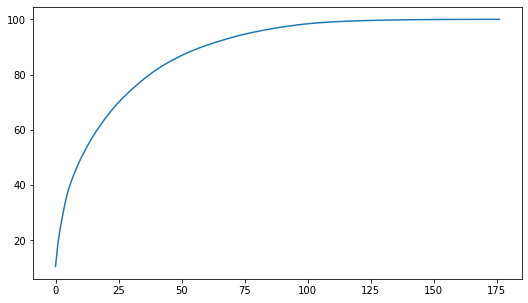

In [64]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

##### Insight: From the above scree plot we can infer that 90% of the total variance is explained by 60 independent variables

<h3> 6.1.1 PCA with Logistic Regression</h3>

In [65]:
# create pipeline
PCA_VARS = 60
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(steps)

In [66]:
# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

0.8125238095238095

In [67]:
# predict churn on test data
y_pred = pipeline.predict(X_test)

# confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[6711 1558]
 [ 125  607]]


In [68]:
# check sensitivity and specificity
sensitivity_and_specificity(confusion)

#ROC
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("ROC: ", (round(roc_auc_score(y_test, y_pred_prob),2)))

Sensitivity:  0.8292349726775956
Specificity:  0.811585439593663
ROC:  0.89


<h3> 6.1.2 Hyper parameter tuning </h3>

In [69]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight='balanced')

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [70]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [60, 80]},
             scoring='roc_auc', verbose=1)

In [71]:
# best score and hyperparameters
print("Best Score: ", model.best_score_)
print("hyperparameters: ", model.best_params_)

Best Score:  0.8905669630546047
hyperparameters:  {'logistic__C': 0.5, 'logistic__penalty': 'l2', 'pca__n_components': 80}


In [72]:
# predict churn on test data
y_pred = model.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# check sensitivity and specificity
sensitivity_and_specificity(cm)

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

Sensitivity:  0.8292349726775956
Specificity:  0.8166646511065425
ROC:    	 0.89


##### Insight: Since the sensitivity is high , this model of PCA with logistic Regression is recommended

<h2>6.2 Random Forest</h2>

In [73]:
# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(class_weight='balanced', n_jobs = -1)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# create gridsearch object
model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [74]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 0.4]},
             scoring='roc_auc', verbose=1)

In [75]:
# Best Score and hyperparameters
print("Best Score: ", model.best_score_)
print("hyperparameters: ", model.best_params_)

Best Score:  0.9306018594601028
hyperparameters:  {'criterion': 'entropy', 'max_features': 0.4}


In [76]:
# predict churn on test data
y_pred = model.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# check sensitivity and specificity
sensitivity_and_specificity(cm)

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("ROC: ", round(roc_auc_score(y_test, y_pred_prob),2))

Sensitivity:  0.45901639344262296
Specificity:  0.9842786310315637
ROC:  0.93


##### The sensitivity is very low and hence will not be useful for the use case of predicting telecom churn

<h2>6.3 Fetch Top N features using random forest and run logistic regression</h2>

In [77]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node

rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight='balanced', oob_score=True, random_state=4, verbose=1)

In [78]:

# fit model
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.7s finished


RandomForestClassifier(class_weight='balanced', max_features=13, oob_score=True,
                       random_state=4, verbose=1)

In [79]:
# predict churn on test data
y_pred = rf_model.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity_and_specificity(cm)

# check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[8160  109]
 [ 416  316]]
Sensitivity:  0.43169398907103823
Specificity:  0.9868182367880034
AUC:    	 0.92


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [80]:
# predictors
features = telecom_df.drop('churn', axis=1).columns

# feature_importance
importance = rf_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)

In [81]:
# extract top 'n' features

top_features = feature_importance.variables[0:20]

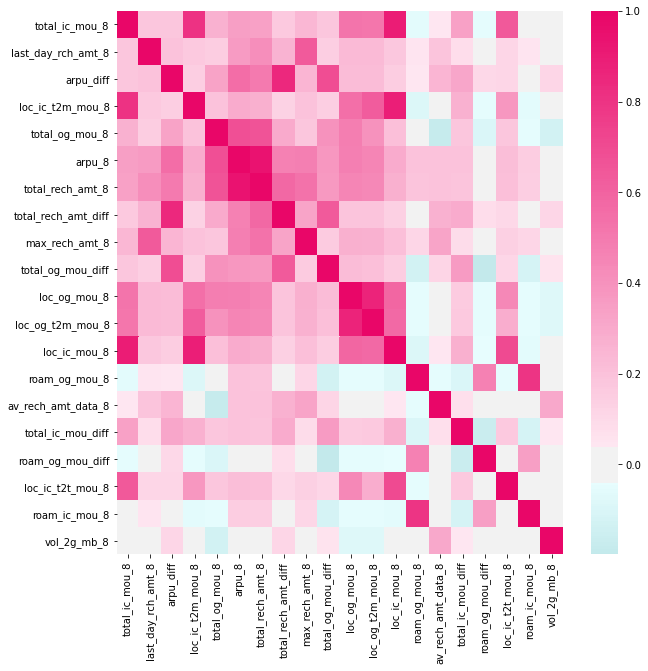

In [82]:
# plot feature correlation
plt.rcParams["figure.figsize"] =(10,10)
mycmap = sns.diverging_palette(199, 359, s=99, center="light", as_cmap=True)
sns.heatmap(data=X_train[top_features].corr(), center=0.0, cmap=mycmap)

In [83]:
X_train = X_train[top_features]
X_test = X_test[top_features]

In [84]:
# logistic regression
steps = [('scaler', StandardScaler()), 
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]

# compile pipeline
logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [85]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [86]:
# best score and hyperparameters
print("Best Score: ", model.best_score_)
print("hyperparameters: ", model.best_params_)

Best Score:  0.8869461246927439
hyperparameters:  {'logistic__C': 10, 'logistic__penalty': 'l2'}


In [87]:
# predict churn on test data
y_pred = model.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# check sensitivity and specificity
sensitivity_and_specificity(cm)

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

Sensitivity:  0.8155737704918032
Specificity:  0.811585439593663
ROC:    	 0.88


In [88]:
logistic_model = model.best_estimator_.named_steps['logistic']

In [89]:
# intercept
intercept_df = pd.DataFrame(logistic_model.intercept_.reshape((1,1)), columns = ['intercept'])

In [90]:
# coefficients

logistic_features = list(X_train.columns)
coefficients_df = pd.DataFrame(logistic_model.coef_, columns=logistic_features)

In [91]:
# concatenate dataframes
coefficients = pd.concat([intercept_df, coefficients_df], axis=1)
#coefficients.sort_values(ascending=False)
coefficients.transpose()


,0
intercept,-1.378242
total_ic_mou_8,-1.762898
last_day_rch_amt_8,-0.442068
arpu_diff,-0.119510
loc_ic_t2m_mou_8,-0.747824
total_og_mou_8,-0.391729
arpu_8,0.301735
total_rech_amt_8,0.044911
total_rech_amt_diff,-0.382454
max_rech_amt_8,0.224513


##### Business Recommendations -
##### Based on the analysis, the Telecom company needs to look into the following columns that can produce a high churn rate.

1.loc_ic_mou_8<br>
2.loc_ic_t2t_mou_8<br>
3.loc_ic_t2m_mou_8<br>
4.av_rech_amt_data_8<br>
5.vol_2g_mb_8<br>
6.loc_og_mou_8<br>
7.last_day_rch_amt_8<br>
8.loc_og_mou_8<br>
9.max_rech_amt_8<br>
10.total_rech_amt_diff

